CONTEXTE : Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

OBJECTIF : vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

NB : Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)


TO DO :
En + : Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.


CONSEILS :
L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données / DATA LEAKS). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

#### Features to predict :

##### Energy Use :

- **SourceEUI(kBtu/sf)** : Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.


- **SiteEnergyUse(kBtu)** : The annual amount of energy consumed by the property from all sources of energy.

- **SteamUse(kBtu)** : The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).

- **Electricity(kBtu)** : The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).

- **NaturalGas(kBtu)** : The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu).

##### Greenhouse Gas Emissions :

- **TotalGHGEmissions** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.


### Importing libraries

In [850]:
%reset -f

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


# PART 1 : Cleaning dataset

### 1) Visualizing dataset

#### 1.1) Global statistics

What's in this Dataset?
Rows : 3,376
Columns : 46
Each row is a : Building



source : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [851]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# load raw dataset
#all_data = pd.read_csv("dataset/2016_Building_Energy_Benchmarking.csv", sep = ',', encoding = 'utf-8')
raw_data = pd.read_csv("dataset/2016_Building_Energy_Benchmarking.csv")

display(raw_data)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00,0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,88434.00,NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00,0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00,0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,756493.00,NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00,0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,61320.00,NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00,0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.57,-122.31,1990,1.00,1,12294,0,12294,Office,Office,12294.00,NaN,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.60,-122.32,2004,1.00,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.64,-122.36,1974,1.00,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Cen

In [852]:
# Primary Key : OSEBuilding ID
raw_data["OSEBuildingID"].unique().shape

(3376,)

In [853]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [854]:
raw_data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.00,3376.00,3360.00,3376.00,3376.00,3376.00,3376.00,3368.00,3376.00,3376.00,3376.00,3376.00,3356.00,1679.00,596.00,2533.00,3369.00,3370.00,3367.00,3367.00,3371.00,3370.00,3367.00,3367.00,3367.00,3367.00,3367.00,0.00,3367.00,3367.00
mean,21208.99,2016.00,98116.95,4.44,47.62,-122.33,1968.57,1.11,4.71,94833.54,8001.53,86832.01,79177.64,28444.08,11738.68,67.92,54.73,57.03,134.23,137.78,5403667.29,5276725.71,274595.90,1086638.97,3707612.16,13685.05,1368504.54,NaN,119.72,1.18
std,12223.76,0.00,18.62,2.12,0.05,0.03,33.09,2.11,5.49,218837.61,32326.72,207939.81,201703.41,54392.92,29331.20,26.87,56.27,57.16,139.29,139.11,21610628.63,15938786.48,3912173.39,4352478.36,14850656.14,67097.81,6709780.83,NaN,538.83,1.82
min,1.00,2016.00,98006.00,1.00,47.50,-122.41,1900.00,0.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,1.00,0.00,0.00,0.00,-2.10,0.00,0.00,0.00,-33826.80,-115417.00,0.00,0.00,NaN,-0.80,-0.02
25%,19990.75,2016.00,98105.00,3.00,47.60,-122.35,1948.00,1.00,2.00,28487.00,0.00,27756.00,25094.75,5000.00,2239.00,53.00,27.90,29.40,74.70,78.40,925128.59,970182.23,0.00,187422.95,639487.00,0.00,0.00,NaN,9.50,0.21
50%,23112.00,2016.00,98115.00,4.00,47.62,-122.33,1975.00,1.00,4.00,44175.00,0.00,43216.00,39894.00,10664.00,5043.00,75.00,38.60,40.90,96.20,101.10,1803753.25,1904452.00,0.00,345129.91,1177583.00,3237.54,323754.00,NaN,33.92,0.61
75%,25994.25,2016.00,98122.00,7.00,47.66,-122.32,1997.00,1.00,5.00,90992.00,0.00,84276.25,76200.25,26640.00,10138.75,90.00,60.40,64.28,143.90,148.35,4222455.25,4381429.12,0.00,829317.84,2829632.50,11890.33,1189033.50,NaN,93.94,1.37
max,50226.00,2016.00,98272.00,7.00,47.73,-122.22,2015.00,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,686750.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,NaN,16870.98,34.09


#### 1.2) Visualizing building types

In [855]:
all_data = raw_data.copy()

all_building_types = all_data["BuildingType"].unique().tolist()
print(all_building_types, end='\n\n')

all_primary_types = all_data["PrimaryPropertyType"].unique().tolist()
print(all_primary_types, end='\n\n')

all_largest_property_use_type = all_data["LargestPropertyUseType"].unique().tolist()
print(all_largest_property_use_type, end='\n\n')

['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)', 'Nonresidential WA']

['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution Center', 'Worship Facility', 'Low-Rise Multifamily', 'Supermarket / Grocery Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily', 'Office']

['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School', 'College/University', 'Automobile Dealership', 'Office', 'Self-Storage Facility', 'Non-Refrigerated Warehouse', 'Other - Mall', 'Senior Care Community', 'Medical Office', 'Retail S

In [856]:
residential_BuildingType = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']
residendial_buildings = all_data[all_data["BuildingType"].isin(residential_BuildingType)]

print("If we remove the buildings which BuildingType is 'Multifamily MR (5-9)', 'Multifamily LR (1-4)' or 'Multifamily HR (10+)', then we lose :", residendial_buildings.shape[0], "which is half of our dataset.")

If we remove the buildings which BuildingType is 'Multifamily MR (5-9)', 'Multifamily LR (1-4)' or 'Multifamily HR (10+)', then we lose : 1708 which is half of our dataset.


### 2) Filling ZipCode with k-NN

19 unique neighborhoods, but because of upper case / lower case we get 14 neighborhoods.

The buildings are all located in the same city (Seattle), so we won't use their localisation to predict the Energy Use and GHG Emissions.
We will use CouncilDistrictCode and ZipCode to localize the buildings.

About the localization of the buildings, we will use the ZipCode, however we have 16 missing values, we tried to fill them with a k-NN.

This k-NN below was used for practice purposes. The correct missing ZipCodes were found by searching on internet with the address.


#### 2.1) Preparing ZipCode data

In [857]:
all_zipcode = all_data["ZipCode"].unique().tolist()
print("We have :", len(all_zipcode), "unique zipcodes.")

# DataFrame with 16 missing ZipCodes
zipcode_na_df = all_data[all_data["ZipCode"].isna()]
print("We have :", zipcode_na_df.shape[0], "missing ZipCodes.")

# We make a list with the address of the building for which the ZipCode is missing.
zipcode_na_list_address = zipcode_na_df["Address"].tolist()
zipcode_na_list = [[i, ""] for i in zipcode_na_list_address]

We have : 56 unique zipcodes.
We have : 16 missing ZipCodes.


In [858]:
# This is the list of zipcodes for each of the 16 missing zipcode. We found it on searching on internet using the Address
correct_zipcode = [98125, 98144, 98117, 98125, 98107, 98117, 98119, 98112, 98122, 98118, 98126, 98108, 98104, 98119, 98108, 98108]
#print(len(right_zipcode))

for i, zipcode in enumerate(correct_zipcode):
    zipcode_na_list[i][1] = zipcode

print(zipcode_na_list)

[['10510 5th Ave NE', 98125], ['405 MLK Jr Way S', 98144], ['8729 15th Ave NW', 98117], ['2806 NE 127th St', 98125], ['6020 28th ave NW', 98107], ['1471 NW 67th St', 98117], ['1403 w howe', 98119], ['1400 E Galer St', 98112], ['2323 East Cherry St', 98122], ['4420 S Genesee', 98118], ['6920 34th Ave SW', 98126], ['1600 S Dakota St', 98108], ['719 8th Ave S', 98104], ['1920 1st Ave W', 98119], ['8319 8th Ave S', 98108], ['2820 S Myrtle St', 98108]]


#### 2.2) ZipCode k-NN

In [859]:
# K-NN

# 0) data / target
zipcode_not_na = all_data[~all_data["ZipCode"].isna()]

target = zipcode_not_na["ZipCode"]
display(target.shape)

X = zipcode_not_na[["Latitude", "Longitude", "CouncilDistrictCode"]]
display(X.shape)

# 1) Sampling
from sklearn.model_selection import train_test_split
# X = data and y = target
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8)

(3360,)

(3360, 3)

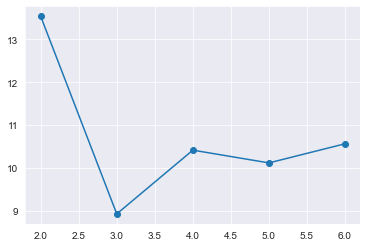

In [860]:
# 2) k-NN and evaluation
from sklearn import neighbors

# Loop on several models ! and check for which value of the hyperparameter k we get the least error percentage.
errors = []
k_start, k_end = 2, 7
for k in range(k_start, k_end):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    # We "fit" the model to our training data and compute the percentage of correct predictions with "score"
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(k_start, k_end), errors, 'o-')
plt.show()

In [861]:
# 3) predict !!
# We use the best classifier to predict
k = 3
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

X_pred = zipcode_na_df[["Latitude", "Longitude", "CouncilDistrictCode"]] # 16 missing postal code
correct_target = np.array(correct_zipcode, dtype=np.float64) # 16 correct ZipCodes / dtype so that it won't be int32

y_pred = knn.predict(X_pred)
print(y_pred)
print(correct_target)

# Accuracy of what X_pred predicted (y_pred) and correct_targer
knn.score(X_pred, correct_target)
# Accuracy 14/16 = 0.875, means two wrong predictions.
# Accuracy 15/16 = 0.9375, means one wrong prediction. ;) with CouncilDistrict we get better results ;)

error = 1 - knn.score(X_pred, correct_target)
print('Error in prediction : %.3f' % error) # .1 means 1 decimal, .2 means 2 decimals
print('Error in prediction : {:.1%}'.format(error))

[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98102. 98122. 98118.
 98126. 98108. 98104. 98109. 98108. 98118.]
[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98112. 98122. 98118.
 98126. 98108. 98104. 98119. 98108. 98108.]
Error in prediction : 0.188
Error in prediction : 18.8%


In [862]:
print("We replace the missing ZipCodes by their correct value.")

#zipcode_na_df.index
# We iterate on the index of the buildings for which the ZipCode is missing
all_data_v1 = all_data.copy()
for i, index in enumerate(zipcode_na_df.index):
    all_data_v1.at[index, "ZipCode"] = correct_zipcode[i]

# Verification
#all_data_v1["ZipCode"].shape
display(all_data_v1[all_data_v1["ZipCode"].isna()])


We replace the missing ZipCodes by their correct value.


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


### 3) Dropping features

We have 46 columns / features to represent each building.

We select the interesting features that will help us predict the energy consumption of the buildings.

We keep for now **ComplianceStatus** and **Outlier** so that we can remove outlier buildings.

In [863]:
columns_to_drop = ["PropertyName", "ListOfAllPropertyUseTypes", "Address", "City", "State", "TaxParcelIdentificationNumber", "Neighborhood", "YearsENERGYSTARCertified", "DefaultData", "Comments", "Latitude", "Longitude"]

print("We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.")

We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.


In [864]:
def drop_selected_features(data_frame, list_features_to_drop):
    """

    :param data_frame:
    :param list_features_to_drop:
    :return:
    """
    df = data_frame.drop(columns=list_features_to_drop)
    return df

all_data_v1 = drop_selected_features(all_data_v1, columns_to_drop)
display(all_data_v1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,98101.00,7,1927,1.00,12,88434,0,88434,Hotel,88434.00,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,98101.00,7,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,98101.00,7,1969,1.00,41,956110,196718,759392,Hotel,756493.00,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,98101.00,7,1926,1.00,10,61320,0,61320,Hotel,61320.00,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,98121.00,7,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,98108.00,2,1990,1.00,1,12294,0,12294,Office,12294.00,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,98104.00,2,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,98119.00,7,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,98108.00,1,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,Compliant,NaN,22.11,1.57


### 4) Verifying GFA

In [865]:
# df = all_data[["PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking"]]
# df.describe()

def verify_PropertyGFA(data_frame):
    """

    :param data_frame:
    :return:

    :UC: 100% filled df[["PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking"]]
    """
    df = data_frame.copy()
    df = df[["PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking"]]
    for index, row in df.iterrows():
        if row["PropertyGFATotal"] != row["PropertyGFABuilding(s)"] + row["PropertyGFAParking"]:
            print("HERE : ", index, row)
    print("End of checking.")

verify_PropertyGFA(all_data_v1)


End of checking.


We have checked that the Total Property GFA is equal to the Total Building(s) GFA + Total Parking GFA.

### 5) Verifying Property Use Type

In [866]:
def fill_property_use_type_GFA(data_frame):
    """

    :param data_frame:
    :return:
    """
    # 1) dropna for LargestPropertyUseTypeGFA
    rows_to_drop = data_frame[data_frame["LargestPropertyUseTypeGFA"].isna()]
    index_to_drop = rows_to_drop.index

    # 2) we drop all the rows for which we have a NaN for LargestPropertyUseTypeGFA
    df = data_frame.copy()
    df = df.drop(index=index_to_drop)

    # 3) We fill the NaN for SecondLargestPropertyUseTypeGFA and ThirdLargestPropertyUseTypeGFA
    df["SecondLargestPropertyUseTypeGFA"] = df["SecondLargestPropertyUseTypeGFA"].fillna(0)
    df["ThirdLargestPropertyUseTypeGFA"] = df["ThirdLargestPropertyUseTypeGFA"].fillna(0)

    df["SecondLargestPropertyUseType"] = df["SecondLargestPropertyUseType"].fillna("None")
    df["ThirdLargestPropertyUseType"] = df["ThirdLargestPropertyUseType"].fillna("None")

    return df

all_data_v2 = fill_property_use_type_GFA(all_data_v1)

display(all_data_v2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,98101.00,7,1927,1.00,12,88434,0,88434,Hotel,88434.00,None,0.00,None,0.00,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,98101.00,7,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,98101.00,7,1969,1.00,41,956110,196718,759392,Hotel,756493.00,None,0.00,None,0.00,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,98101.00,7,1926,1.00,10,61320,0,61320,Hotel,61320.00,None,0.00,None,0.00,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,98121.00,7,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,98108.00,2,1990,1.00,1,12294,0,12294,Office,12294.00,None,0.00,None,0.00,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,98104.00,2,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,None,0.00,None,0.00,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,98119.00,7,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,98108.00,1,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,Compliant,NaN,22.11,1.57


We have filled Second and Third Property Use Type GFA by 0 (meaning there are no second or  third use for the building.
We have also filled the Second and Third Property USe Type by "None".

### 6) Outliers cleaning

#### 1) outliers described in the dataset

Outlier : Whether a property is a high or low outlier

In [867]:
print("Checking Outliers.")

# We have a column called "Outlier" in which we have 32 buildings which are considered outliers.
outliers_examples = all_data_v2[~all_data_v2["Outlier"].isna()]

display(outliers_examples)

Checking Outliers.


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,98101.00,7,1958,1.00,6,172842,25920,146922,Office,99890.00,Data Center,39336.00,Parking,25000.00,NaN,297.40,299.20,909.60,911.50,41399504.00,41650404.00,0.00,11663150.00,39794668.00,16048.31,1604831.00,Non-Compliant,High outlier,362.66,2.10
384,539,2016,NonResidential,Retail Store,98105.00,4,1987,1.00,2,69492,0,69492,Retail Store,69800.00,Other,0.00,None,0.00,100.00,4.60,4.60,14.30,14.30,318962.81,318962.81,0.00,93482.60,318963.00,0.00,0.00,Non-Compliant,Low outlier,2.22,0.03
448,608,2016,NonResidential,Large Office,98104.00,2,1913,5.00,7,154159,0,154159,Office,193154.00,None,0.00,None,0.00,100.00,58.00,58.80,28.00,28.70,11195917.00,11348758.00,0.00,471503.00,1608768.00,3430.50,343050.00,Non-Compliant,Low outlier,29.43,0.19
517,704,2016,NonResidential,Large Office,98119.00,7,2000,1.00,4,129551,42500,87051,Office,82273.00,Parking,42500.00,Data Center,4778.00,1.00,311.70,311.70,978.90,978.90,27137190.00,27137190.00,0.00,7953454.50,27137187.00,0.00,0.00,Non-Compliant,High outlier,189.18,1.46
720,19708,2016,Multifamily HR (10+),High-Rise Multifamily,98121.00,7,1982,1.00,24,167941,0,167941,Multifamily Housing,138787.00,Parking,99952.00,Swimming Pool,0.00,100.00,17.30,18.70,50.40,54.00,2407904.50,2589125.50,0.00,626561.62,2137828.00,2700.76,270076.00,Non-Compliant,Low outlier,29.25,0.17
834,19934,2016,Multifamily LR (1-4),Low-Rise Multifamily,98102.00,3,1989,1.00,4,31702,0,31702,Multifamily Housing,26418.00,Parking,14280.00,None,0.00,NaN,9.70,10.40,30.40,32.70,255971.20,275412.00,0.00,75020.90,255971.00,0.00,0.00,Non-Compliant,Low outlier,1.78,0.06
839,19967,2016,SPS-District K-12,K-12 School,98109.00,7,2001,1.00,1,35805,0,35805,K-12 School,35805.00,None,0.00,None,0.00,100.00,12.10,12.10,27.00,27.00,431471.69,431471.69,0.00,72282.40,246628.00,1848.44,184844.00,Error - Correct Default Data,Low outlier,11.54,0.32
962,20367,2016,Multifamily LR (1-4),Low-Rise Multifamily,98126.00,1,1990,1.00,3,70207,0,70207,Multifamily Housing,71273.00,None,0.00,None,0.00,100.00,9.90,9.90,30.90,30.90,702481.38,702481.38,0.00,205885.50,702481.00,0.00,0.00,Non-Compliant,Low outlier,4.90,0.07
1045,20617,2016,NonResidential,Retail Store,98134.00,2,1953,1.00,1,39900,0,39900,Retail Store,25000.00,Non-Refrigerated Warehouse,15000.00,None,0.00,100.00,3.60,3.60,6.40,6.40,145468.80,145468.80,0.00,14362.50,49005.00,964.64,96464.00,Error - Correct Default Data,Low outlier,5.46,0.14
1229,21315,2016,NonResidential,Small- and Mid-Sized Office,98101.00,7,1903,1.00,3,57720,0,57720,Office,25000.00,None,0.00,None,0.00,NaN,1.00,1.00,3.00,3.00,24105.50,24105.50,0.00,7064.90,24105.00,0.00,0.00,Non-Compliant,Low outlier,0.17,0.00


#### 2) Compliance Status described in the dataset


In [868]:
print("Checking ComplianceStatus.")
display(all_data_v2["ComplianceStatus"].unique())

non_compliant_status = ['Error - Correct Default Data', 'Missing Data', 'Non-Compliant']

non_compliant_buildings = all_data[all_data["ComplianceStatus"].isin(non_compliant_status)]
display(non_compliant_buildings)

Checking ComplianceStatus.


array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
22,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,5149 S. Graham St.,Seattle,WA,98118.00,1102000138,2,SOUTHEAST,47.55,-122.27,1961,1.00,2,56228,0,56228,K-12 School,K-12 School,58916.00,NaN,NaN,NaN,NaN,NaN,95.00,26.10,29.10,60.70,64.60,1539478.50,1713623.50,0.00,274605.91,936955.00,6025.23,602523.00,True,NaN,Error - Correct Default Data,NaN,38.53,0.69
28,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.00,0688000090,3,Central,47.62,-122.31,1955,1.00,1,126351,0,126351,K-12 School,K-12 School,126351.00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False,NaN,Missing Data,NaN,0.00,0.00
30,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,11051 34th Ave. N.E.,Seattle,WA,98125.00,0752000170,5,NORTH,47.71,-122.29,1949,1.00,2,160645,0,160645,K-12 School,K-12 School,164229.00,NaN,NaN,NaN,NaN,NaN,75.00,41.30,47.50,68.10,75.70,6779173.00,7800349.50,0.00,570809.19,1947601.00,48315.72,4831572.00,True,NaN,Error - Correct Default Data,NaN,270.18,1.68
31,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.00,0809000005,7,MAGNOLIA / QUEEN ANNE,47.63,-122.35,1989,1.00,2,51582,0,51582,K-12 School,K-12 School,55166.00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,438691.69,1496816.00,0.00,0.00,False,NaN,Missing Data,NaN,10.43,0.20
38,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,3003 N.E. 75th St.,Seattle,WA,98115.00,0425049022,4,NORTHEAST,47.68,-122.29,1950,1.00,2,175565,0,175565,K-12 School,K-12 School,182861.00,NaN,NaN,NaN,NaN,NaN,88.00,35.00,40.10,55.00,60.40,6399127.50,7329817.50,0.00,468840.50,1599684.00,47994.43,4799443.00,True,NaN,Error - Correct Default Data,NaN,266.05,1.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,49943,2016,Multifamily LR (1-4),Low-Rise Multifamily,Stewart House,80 Stewart Street,Seattle,WA,98101.00,8008550000,7,DOWNTOWN,47.61,-122.34,1904,1.00,3,49000,0,49000,"Food Sales, Multifamily Housing, Restaurant, R...",Multifamily Housing,21600.00,Food Sales,5663.00,Retail Store,4027.00,NaN,NaN,136.70,139.30,366.80,372.40,4602793.50,4691944.50,0.00,1054888.88,3599281.00,10035.12,1003512.00,False,NaN,Non-Compliant,High outlier,78.39,1.60
3341,50071,2016,Multifamily MR (5-9),Mid-Rise Multifamily,The Westside Off Broadway,801 E Thomas St,Seattle,WA,98102.00,6003501185,3,EAST,47.62,-122.32,2015,1.00,7,41384,15062,26322,"Multifamily Housing, Other - Restaurant/Bar, P...",Multifamily Housing,34643.00,Parking,8266.00,"Personal Services (Health/Beauty, Dry Cleaning...",1714.00,NaN,100.00,0.40,0.40,1.10,1.10,13409.00,13409.00,0.00,3930.00,13409.00,0.00,0.00,False,NaN,Non-Compliant,Low outlier,0.09,0.00
3366,50210,2016,Nonresidential COS,Office,Central West HQ / Brown Bear,1403 w howe,Seattle,WA,NaN,2425039137,7,MAGNOLIA / QUEEN ANNE,47.64,-122.38,1952,1.00,1,13661,0,13661,Office,Office,13661.00,NaN,NaN,NaN,NaN,NaN,75.00,36.80,40.90,115.50,128.40,502667.69,558525.12,0.00,147323.50,502667.78,0.00,0.00,True,NaN,Error - Correct Default Data,NaN,3.

In [869]:
def drop_outliers_based_on_dataset(data_frame):
    """

    :param data_frame:
    :return:
    """
    df = data_frame.copy()

    # ComplianceStatus
    print("Before removing the non compliant buildings :", df.shape)
    non_compliant_status = ['Error - Correct Default Data', 'Missing Data', 'Non-Compliant']
    df = df[~df["ComplianceStatus"].isin(non_compliant_status)]
    print("After removing the non compliant buildings :", df.shape)

    # Outliers
    print("Before removing the 32 outliers :", df.shape)
    df = df[df["Outlier"].isna()]
    print("After removing the outliers :", df.shape)

    print("We delete the columns ComplianceStatus and Outlier.")
    df = drop_selected_features(df, ["ComplianceStatus", "Outlier"])

    return df

all_data_v3 = drop_outliers_based_on_dataset(all_data_v2)

Before removing the non compliant buildings : (3356, 34)
After removing the non compliant buildings : (3196, 34)
Before removing the 32 outliers : (3196, 34)
After removing the outliers : (3196, 34)
We delete the columns ComplianceStatus and Outlier.


In [870]:
print("We have removed 60 buildings which were not compliant. And amongst these 60 buildings, 32 were outliers.")

We have removed 60 buildings which were not compliant. And amongst these 60 buildings, 32 were outliers.


#### 3) Cleaning NaN values

##### 3.1) Removing buildings with NaN values

In [871]:
columns_with_nan = all_data_v3.columns[all_data_v3.isna().any()].tolist()
print("These columns have empty values (NaN) :", columns_with_nan, end='\n\n')
print("For the Energy Star Score, we will keep it untouched until later.", end='\n\n')

x = all_data_v3[all_data_v3["SiteEUIWN(kBtu/sf)"].isna()]
display(x)

y = all_data_v3[all_data_v3["SiteEnergyUseWN(kBtu)"].isna()]
display(y)

These columns have empty values (NaN) : ['ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)']

For the Energy Star Score, we will keep it untouched until later.



,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
563,757,2016,NonResidential,Large Office,98121.00,7,1979,1.00,7,131143,87160,43983,Office,120248.00,Retail Store,10853.00,None,0.00,93.00,39.50,NaN,128.00,0.00,5177270.50,NaN,0.00,1427645.25,4871126.00,14160.41,1416041.00,109.16,0.83


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
563,757,2016,NonResidential,Large Office,98121.00,7,1979,1.00,7,131143,87160,43983,Office,120248.00,Retail Store,10853.00,None,0.00,93.00,39.50,NaN,128.00,0.00,5177270.50,NaN,0.00,1427645.25,4871126.00,14160.41,1416041.00,109.16,0.83


In [872]:
print("We remove 1 building with SiteEUI(kBtu/sf) and SiteEnergyUseWN(kBtu) as NaN.")

def drop_buildings_subset_nan(data_frame, features_to_check):
    """

    :param data_frame:
    :param features_to_check:
    :return:
    """
    #print(data_frame.shape)
    df = data_frame.dropna(subset=features_to_check)
    #print(df.shape)
    return df

features_with_nan = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)"]
all_data_v4 = drop_buildings_subset_nan(all_data_v3, features_with_nan)

We remove 1 building with SiteEUI(kBtu/sf) and SiteEnergyUseWN(kBtu) as NaN.


##### 3.2) Cleaning Energy Star Score

In [873]:
print("ENERGYSTARScore and its NaN :")

print("For the", all_data_v4[all_data_v4["ENERGYSTARScore"].isna()].shape[0], "buildings that do not have an Energy Star Score, we fill it with -1 for now.")
#all_data_v4[all_data_v4["ENERGYSTARScore"].isna()].count

def fill_nan_column_by_value(data_frame, column, value):
    """

    :param data_frame:
    :return:
    """
    df = data_frame.copy()
    df[column] = df[column].fillna(value)
    return df

all_data_v4 = fill_nan_column_by_value(all_data_v4, "ENERGYSTARScore", -1)

ENERGYSTARScore and its NaN :
For the 804 buildings that do not have an Energy Star Score, we fill it with -1 for now.


#### 4) Energy or GHG Outliers (negative electricity or gas)

In [886]:
display(all_data_v4.describe())
print(all_data_v4.shape)


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00
mean,21405.99,2016.00,98116.92,4.48,1968.70,1.11,4.80,95970.22,8375.03,87595.19,79439.12,14552.00,2165.15,50.11,55.71,58.03,136.67,140.22,5548417.82,5404201.28,286430.44,1115524.22,3806168.65,13889.43,1388943.24,122.41,1.19
std,12148.03,0.00,18.75,2.12,33.18,2.16,5.60,223304.16,33139.02,212048.36,205605.41,40108.12,13450.61,37.71,56.84,57.73,139.99,139.73,22163695.04,16323752.47,4012833.37,4458427.38,15212154.21,68783.21,6878320.61,552.52,1.85
min,1.00,2016.00,98006.00,1.00,1900.00,0.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,-1.00,1.40,0.00,0.00,-2.10,57133.20,0.00,0.00,-33826.80,-115417.00,0.00,0.00,-0.80,-0.02
25%,20070.00,2016.00,98105.00,3.00,1948.00,1.00,2.00,28284.00,0.00,27552.00,24989.00,0.00,0.00,-1.00,28.10,29.50,75.50,79.20,940129.16,988072.09,0.00,188439.70,642956.00,0.00,0.00,9.65,0.21
50%,23164.00,2016.00,98115.00,4.00,1975.00,1.00,4.00,43832.00,0.00,42848.00,39000.00,0.00,0.00,60.00,39.30,41.50,97.70,102.90,1809586.75,1908057.88,0.00,347841.41,1186835.00,3214.97,321497.00,34.00,0.62
75%,26010.50,2016.00,98122.00,7.00,1997.00,1.00,5.00,91580.00,0.00,84744.50,76627.50,11400.00,0.00,85.00,61.50,65.55,146.65,151.15,4277746.75,4435780.50,0.00,845344.47,2884315.00,11830.18,1183018.00,94.38,1.38
max,50226.00,2016.00,98272.00,7.00,2015.00,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,639931.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,16870.98,34.09


(3195, 32)
We can see that we have negative values for theses features : 


In [894]:
print("We can see that we have negative values for theses features : ")

all_energy_features = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", "SteamUse(kBtu)", "Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)", "TotalGHGEmissions", "GHGEmissionsIntensity"]

features_with_negative_values = []
for energy_feature in all_energy_features:
    energy_min = all_data_v4[energy_feature].min()
    if energy_min < 0:
        print("For this feature :", energy_feature, "we have this negative value :", energy_min)
        features_with_negative_values.append(energy_feature)

print("This is the list of features for which we will remove outliers :", features_with_negative_values)

We can see that we have negative values for theses features : 
For this feature : SourceEUIWN(kBtu/sf) we have this negative value : -2.099999905
For this feature : Electricity(kWh) we have this negative value : -33826.80078
For this feature : Electricity(kBtu) we have this negative value : -115417.0
For this feature : TotalGHGEmissions we have this negative value : -0.8
For this feature : GHGEmissionsIntensity we have this negative value : -0.02
This is the list of features for which we will remove outliers : ['SourceEUIWN(kBtu/sf)', 'Electricity(kWh)', 'Electricity(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [895]:
def removing_energy_outliers(data_frame, energy_feature, ceiling):
    """

    :param data_frame:
    :param energy_feature:
    :return:
    """
    df = data_frame[data_frame[energy_feature] >= ceiling]
    return df

all_data_v5 = removing_energy_outliers(all_data_v4, "SourceEUIWN(kBtu/sf)", 0)

print("We had one outlier building for which the energy values were negative.")

display(all_data_v5.describe())
print(all_data_v5.shape)

We had one outlier building for which the energy values were negative.


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00
mean,21397.10,2016.00,98116.92,4.48,1968.69,1.11,4.80,95983.99,8377.65,87606.33,79448.91,14556.56,2165.83,50.09,55.73,58.05,136.71,140.27,5550047.66,5405818.09,286520.12,1115884.07,3807396.44,13893.78,1389378.10,122.45,1.19
std,12139.55,0.00,18.75,2.12,33.17,2.16,5.60,223337.77,33143.88,212080.63,205636.86,40113.57,13452.67,37.70,56.84,57.73,140.00,139.73,22166973.95,16326052.59,4013458.50,4459079.08,15214377.80,68793.54,6879353.69,552.60,1.85
min,1.00,2016.00,98006.00,1.00,1900.00,0.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,-1.00,1.40,0.00,0.00,0.00,57133.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,20069.50,2016.00,98105.00,3.00,1948.00,1.00,2.00,28280.50,0.00,27551.50,24988.50,0.00,0.00,-1.00,28.10,29.50,75.52,79.20,940947.84,988526.84,0.00,188527.90,643257.00,0.00,0.00,9.65,0.21
50%,23163.00,2016.00,98115.00,4.00,1975.00,1.00,4.00,43813.00,0.00,42832.00,38996.50,0.00,0.00,60.00,39.30,41.50,97.70,102.90,1810546.56,1910731.06,0.00,347868.66,1186928.00,3214.99,321498.50,34.00,0.62
75%,26007.75,2016.00,98122.00,7.00,1997.00,1.00,5.00,91590.00,0.00,84747.25,76629.25,11400.00,0.00,85.00,61.50,65.57,146.67,151.17,4282593.12,4437788.00,0.00,845612.05,2885228.00,11830.62,1183062.00,94.43,1.38
max,50226.00,2016.00,98272.00,7.00,2015.00,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,639931.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,16870.98,34.09


(3194, 32)


In [896]:
features_with_negative_values = []
for energy_feature in all_energy_features:
    energy_min = all_data_v5[energy_feature].min()
    if energy_min < 0:
        print("For this feature :", energy_feature, "we have this negative value :", energy_min)
        features_with_negative_values.append(energy_feature)


#### 5) Verification Total Energy

We consider that the **Total Energy** of a building is represented by the variable **SiteEnergyUse(kBtu)**.
Thus  **SiteEnergyUse(kBtu)** = **Electricity(kBtu)** + **SteamUse(kBtu)** + **NaturalGas(kBtu)** + **OtherEnergy(kBtu)**

We will compute the difference between the Total Energy and Electricity(kBtu) + SteamUse(kBtu) + NaturalGas(kBtu) and if the difference / error / other energy is greater than 1% we drop the building.

In [899]:
def compute_TotalEnergy(data_frame):
    """

    :param data_frame:
    :return:

    :UC: 100% filled df[["SiteEnergyUse(kBtu)", "Electricity(kBtu)", "SteamUse(kBtu)", "NaturalGas(kBtu)"]]
    """
    df = data_frame.copy()
    # 1) We had a column that computes the difference between the Total Energy and Electricity, SteamUse and NaturalGas
    df["RemainingEnergy(kBtu)"] = df["SiteEnergyUse(kBtu)"] - (df["Electricity(kBtu)"] + df["SteamUse(kBtu)"] + df["NaturalGas(kBtu)"])
    df["RemainingEnergy(%)"] = df["RemainingEnergy(kBtu)"] / df["SiteEnergyUse(kBtu)"]

    #df_energy = df[["SiteEnergyUse(kBtu)", "Electricity(kBtu)", "SteamUse(kBtu)", "NaturalGas(kBtu)", "RemainingEnergy(kBtu)"]]

    return df

x = compute_TotalEnergy(all_data_v5)
display(x)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,RemainingEnergy(kBtu),RemainingEnergy(%)
0,1,2016,NonResidential,Hotel,98101.00,7,1927,1.00,12,88434,0,88434,Hotel,88434.00,None,0.00,None,0.00,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,249.98,2.83,0.50,0.00
1,2,2016,NonResidential,Hotel,98101.00,7,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,295.86,2.86,0.00,0.00
2,3,2016,NonResidential,Hotel,98101.00,7,1969,1.00,41,956110,196718,759392,Hotel,756493.00,None,0.00,None,0.00,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,2089.28,2.19,6.00,0.00
3,5,2016,NonResidential,Hotel,98101.00,7,1926,1.00,10,61320,0,61320,Hotel,61320.00,None,0.00,None,0.00,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,286.43,4.67,0.75,0.00
4,8,2016,NonResidential,Hotel,98121.00,7,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,505.01,2.88,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,50221,2016,Nonresidential COS,Other,98126.00,1,1982,1.00,1,18261,0,18261,Other - Recreation,18261.00,None,0.00,None,0.00,-1.00,51.00,56.20,126.00,136.60,932082.12,1025432.12,0.00,185334.70,632362.01,2997.20,299720.00,20.33,1.11,0.12,0.00
3372,50223,2016,Nonresidential COS,Other,98104.00,2,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,None,0.00,None,0.00,-1.00,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,32.17,2.01,0.16,0.00
3373,50224,2016,Nonresidential COS,Other,98119.00,7,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,-1.00,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,223.54,16.99,0.18,0.00
3374,50225,2016,Nonresidential COS,Mixed Use Property,98108.00,1,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,-1.00,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,22.11,1.57,0.01,0.00


In [900]:
x[x["RemainingEnergy(%)"] > 2]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,RemainingEnergy(kBtu),RemainingEnergy(%)


In [876]:
# MENTOR : verifier la coherence des données (EUI = Electricity + gas + steam ? check somme envirion egale (ecart < 1% / puis les ocrriger les variables ou exlcure

In [877]:
# 90% laisser mais pas l'utiliser au debut
# projet : determiner si l'Energie star score / pour l'instant

print("After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.")
all_data_v7 = all_data_v5.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

# PART 2 : Exploration of the dataset

In [880]:
#dataset = pd.read_csv("dataset/2016_Building_Energy_Cleaned.csv")

Kindergarten through high school (K–12) buildings in the US use an average of 10 kilowatt-hours ( kWh ) of electricity and 50 cubic feet of natural gas per square foot ( ft2 ) annually.

### 7) Plot kWh and kBtu and drop

<AxesSubplot:xlabel='NaturalGas(therms)', ylabel='NaturalGas(kBtu)'>

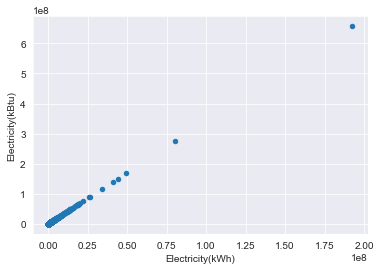

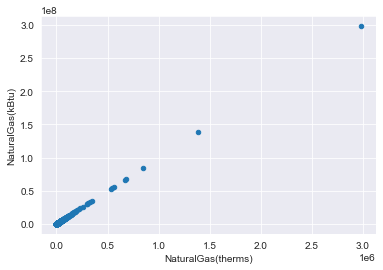

In [881]:
data = all_data_v5
#data.plot.scatter("Electricity(kWh)", "Electricity(kBtu)", c="CouncilDistrictCode", colormap='viridis')
#data.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)", c="CouncilDistrictCode", colormap='viridis')

data.plot.scatter("Electricity(kWh)", "Electricity(kBtu)")
data.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)")

In [882]:
print("After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.")
all_data_v7 = all_data_v5.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.


### TODO :

3) Property type (12) to numbers ?? (graph and cross data !!!)
4) graphs (scatter plots, boxplot, describe, correlation matrix)

In [883]:
#dataset = pd.read_csv("dataset/2016_Building_Energy_Cleaned.csv")

# matrice corr
# distribution


# nettoyer : filtrer en ligne / quelques graphiques pour la presentation et mieux visualier / pour justifier des filtres

# exploration : features et var à prédire / matrice de corr / gtaphiques de distribution (var categorielles)

# à la fin du premier notebook / csv : bat propres et colonnes pour prediction

# 1) notebook par var à predire (tres propres et exaustif) : MAX TEMPS
# 2) dupliquer

# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire



In [884]:
# exploration : matrice corrélation et corrélation entre categorielles et quantitatives (GHGE corrélé avec var consom E (elctricity, steam etc)
# predict : consomation bat puis avec ca predire l'emission CO2
# 1) prediction consommation sur l'énergie puis predire CO2 (le + long le +complexe)
# categories batiments mal ecrites / numeriques incohérentes

In [885]:
print("Source Energy Accounts for Total Energy Use")
features_to_predict = [
    "SourceEUI(kBtu/sf)",
"SiteEnergyUse(kBtu)",
"SteamUse(kBtu)",
"Electricity(kBtu)",
"NaturalGas(kBtu)",
"TotalGHGEmissions"]

print("Features to predict : ", features_to_predict)

Source Energy Accounts for Total Energy Use
Features to predict :  ['SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']
